# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
np.set_printoptions(precision=3)
import scipy as sp
 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
mpl.rcParams['savefig.dpi'] = 300
from IPython.core.pylabtools import figsize
#%matplotlib notebook
%matplotlib inline

#import h5py
from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('Q2/Data/', exist_ok=True)
os.makedirs('Q2/Figs/', exist_ok=True)

# Q0. Load the data and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''to keep the nexus format. The data format is slightly difffernt to np array.'''
_intsy = data['intensity']
_QQs = data['Q']
_dds = data['dspacing']
_temps = data['temperature']

'''convert to numpy array'''
intsy = np.asarray(_intsy)
QQs = np.asarray(_QQs)
dds = np.asarray(_dds)
temps = np.asarray(_temps)
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2

# Q2.  Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.

    We will examine the characterstic of the data in ROI as a function of temperature. As we did in Q1, we determine the signal and bakcground regions. We aims at using global information in determining the background level.   

## 2.1 Characterstic of the data between 3.2 and 3.3 Å as a function of temperature.

In [20]:
def _getNXunits(nxitem):
    '''return the unit of an nxitem if existed'''
    if 'units' in nxitem.attrs:
        return nxitem.attrs['units']
    return   ''

def plot_mlines(IntsyMap, pars, pars2plot, bins, binrange, **args):
    '''
    input parameters:
        pars: NXfield, an array of the full parameter space. 
        par_range to plot: an array of parameters to plot.
        bins: NXfiled, an array of the bin edges.
        binrange: [low, high] bin value to plot.
    '''
    npars, nbins = IntsyMap.shape
    
    if npars != len(pars):
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
    
    if nbins != len(bins)-1:
        raise ValueError("Dimension mismatch on number of bins.")  
        
    bin_cs = (bins[:-1] + bins[1:])/2
    
    par_unit = _getNXunits(pars) 
    bin_unit = _getNXunits(bins)
    signal_unit = _getNXunits(IntsyMap)
    
    min_bin, max_bin = bin_cs.index(binrange[0]), bin_cs.index(binrange[1])
    xx = np.asarray(bin_cs)[min_bin : max_bin]
    intsy_roi = IntsyMap[:, min_bin:max_bin]
    ymin, ymax = 0, 0
    
    for _par in pars2plot:
        ii = (np.abs(pars - _par)).argmin()
        label= '%5.2f' %pars[ii] + ' ' + par_unit
        yy = np.asarray(intsy_roi[ii,:])
        ymin, ymax = min(ymin, yy.min()), max(ymax, yy.max())
        #plt.plot(xx, yy, '.-', label=label)
        plt.plot(xx, yy, '.-', color='b', label=label)

   
    plt.xlim(binrange)
    plt.xlabel(bins.nxname + " (" + bin_unit + ")" )
    dy = (ymax-ymin) 
    ymin, ymax = ymin-dy*0.05, ymax+dy*0.2
    plt.ylim(ymin, ymax)
    plt.ylabel(IntsyMap.nxname + " (" + signal_unit + ")")
    plt.legend(loc=1)
     
    if 'figtitle' in args:
        figtitle = args['figtitle']
        if (len(figtitle) != 0):
            plt.title(figtitle)
    
    plt.tight_layout()
    
    if 'filename' in args:
        filename = args['filename']
        if ( len(filename) != 0):
            plt.savefig(filename)
    
    return

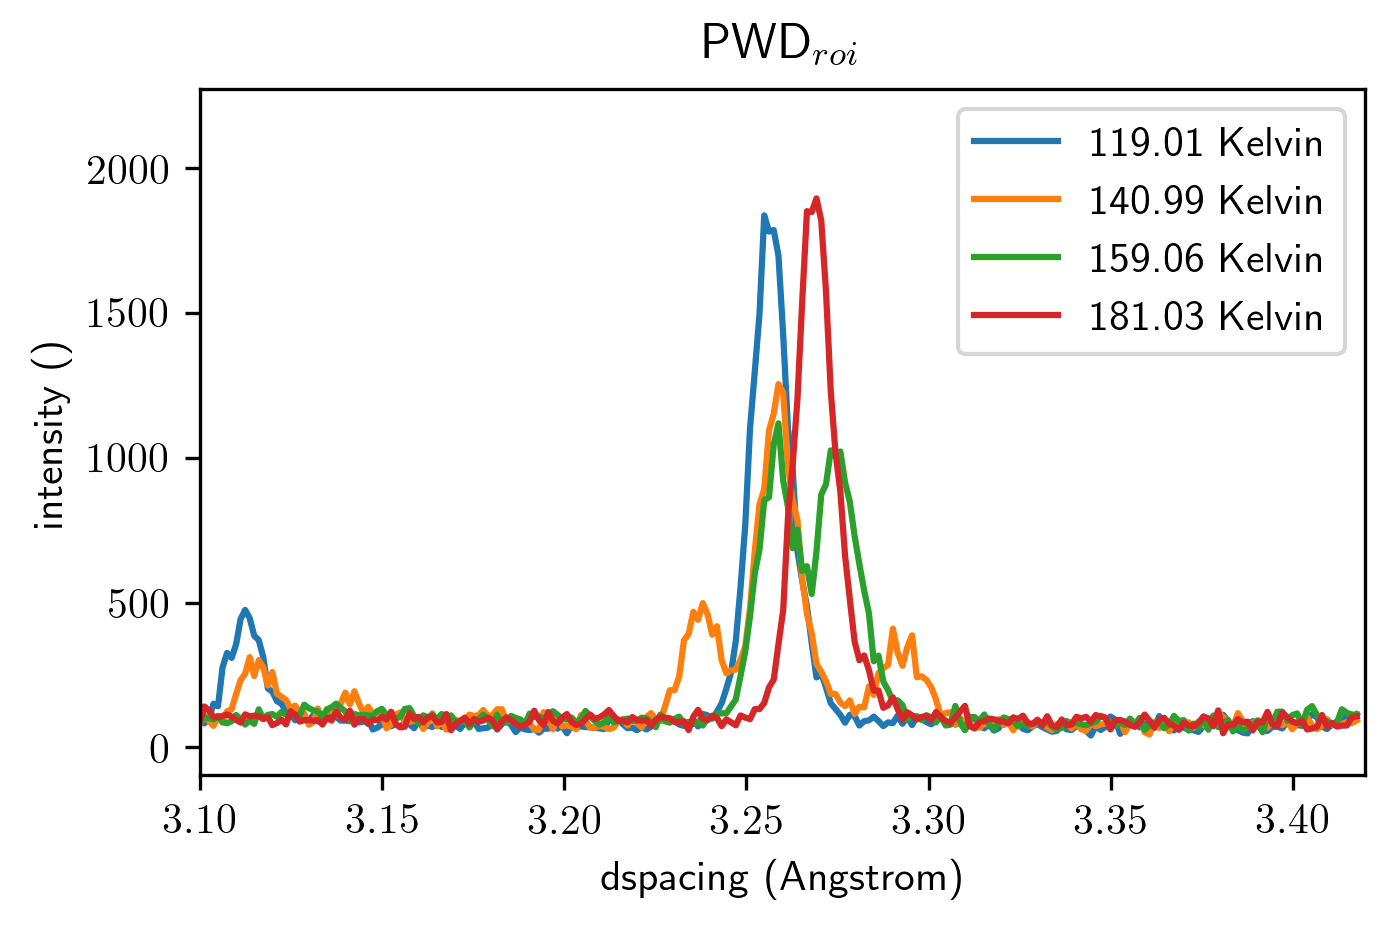

In [4]:
plt.figure(figsize(4.8, 3.2))
drange = [3.1, 3.42]
temprange = np.arange(120, 200, 20)
plot_mlines(_intsy, _temps, temprange, _dds, drange, figtitle = 'PWD_{roi}', filename = 'Q2/Figs/PWD_ROI.png')

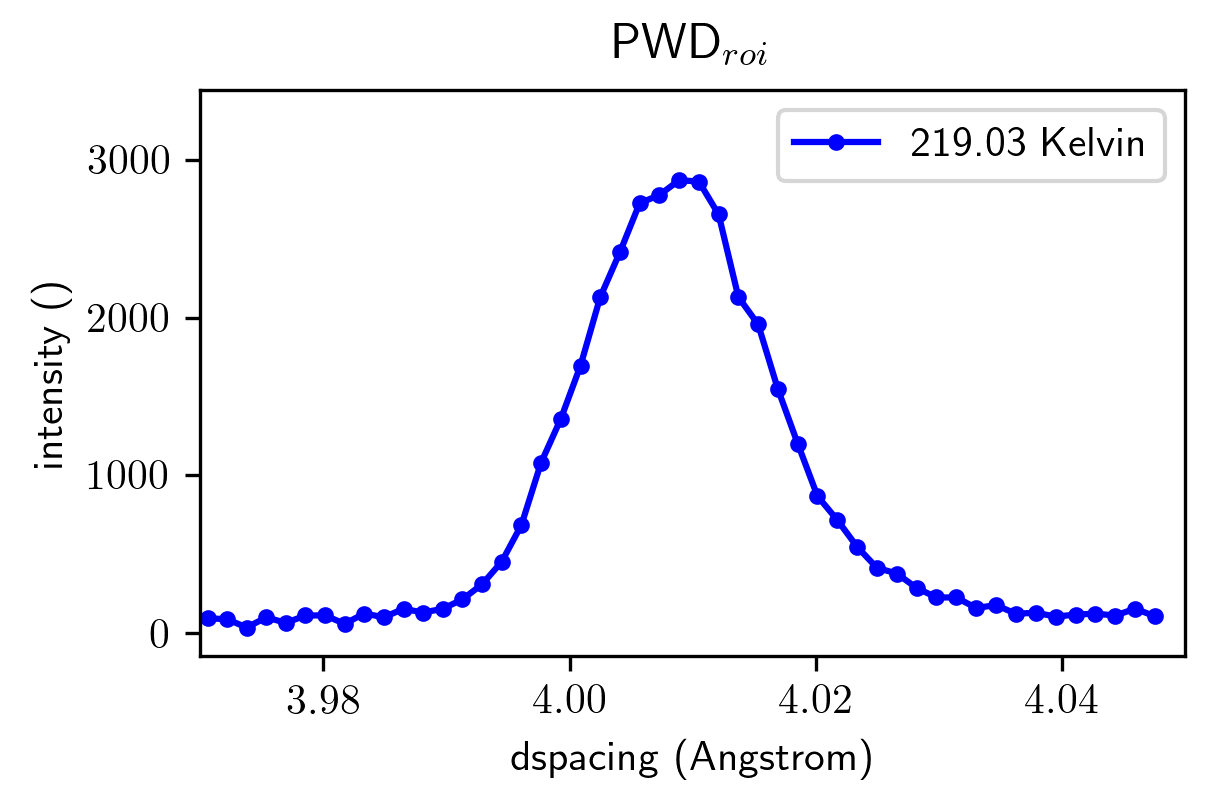

In [22]:
plt.figure(figsize(4.2, 2.8))
drange = [3.97, 4.05]
temprange = np.arange(220, 221, 2)
filename = 'Q2/Figs/PWD_ROI_%d.png' %220
plot_mlines(_intsy, _temps, temprange, _dds, drange, 
            figtitle = 'PWD_{roi}', filename = filename )

## 2.2 Similar to Q0, determining the backgrond level and removing the background.

In [5]:
def Plot_Clustering(db, signal, pars, bin_cs, x_roi=[], savefilename=""):
    '''
    plot the results of DBScan:
        pnt_loc 
        signal = -1, plot background point
        signal = others, plot signal point
        
        x_roi: the region of interest for plotting the results.
    '''
    
    binindex = np.arange(len(bin_cs)) 
    parindex = np.arange(len(pars))
    xx, yy = np.meshgrid(binindex, tempindex)
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    if signal == -1:
        _xx, _yy = pnt_loc[db.labels_ == -1].T
        title = 'Bkg points by DBSCAN.'
    else:
        _xx, _yy = pnt_loc[db.labels_ != -1].T
        title = 'Signal above background found by DBSCAN.'

    _xx = dd_cs[_xx]
    _yy = pars[_yy]
    
    plt.figure()
    plt.plot(_xx, _yy, '.', markerfacecolor='blue',
                 markeredgecolor='none', markersize=2)
    plt.xlabel('d-spacing(\AA)')
    plt.ylabel('temperature (K)')
    if len(x_roi) == 2:
        xlims = x_roi
    else:
        xlims = [_xx.min(), _xx.max()]
    ylims = [_yy.min()-5, _yy.max()+5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.tight_layout()
    plt.title(title)
    if len(savefilename) > 0:
        plt.savefig(savefilename, dpi=600)
    plt.show()    
    return


def Find_clusters_stats(IntsyMap, db, bin_cs, x_roi=[]):
    '''
    Return the integrated intensity, center and width of the clustering 
    results in the x-roi
    
    * using background removed data as an input to get signal-only intensity
    '''
    
    npars, nbins = IntsyMap.shape
    
    if nbins != len(bin_cs):
        raise ValueError("Dimension mismatch on number of bins.")  
    
    if len(x_roi) !=2:
        raise ValueError("roi needs exactly two numbers.")  
    elif x_roi[0] > x_roi[1]:
        x_roi[0], x_roi[1] = x_roi[1], x_roi[0]
    
    binindx = np.arange(nbins) 
    parindx = np.arange(npars)
    xx, yy = np.meshgrid(binindx, parindx)
    pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
    
    _xx, _yy = pnt_loc[db.labels_ != -1].T
    
    signalloc, signal, widths, centers = [], [], [], []
    for ii in range(npars):
        _signalloc = _xx[_yy==ii]
        _signal = IntsyMap[ii, _signalloc]
        
        _signalloc = bin_cs[_signalloc]
        roi_mask = (_signalloc >= x_roi[0]) & (_signalloc <= x_roi[1])
        _signalloc = _signalloc[roi_mask]
        _signal = _signal[roi_mask]
        
        signal.append(_signal)
        signalloc.append(_signalloc)
        widths.append(_signalloc[-1] - _signalloc[0])
        centers.append(_signalloc.mean())
    
    return signal, signalloc, widths, centers


def rm_Global_Bkg(Coef, IntsyMap, pars, bin_cs, Par_Order=1, Bin_Order =1):
    '''
    A fitting functino for the background of a 2D data.
    bkg = C0 + C1 * pars + C2 * pars^2 + ... + C(Par_Order+1) * bins_center+ ...
    '''
    
    npars, nbins = IntsyMap.shape
    
    if len(Coef) != (1 + Par_Order + Bin_Order):
        raise ValueError("Dimension mismatch on number of Coef.") 
    
    if npars != len(pars):
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
        
    if nbins != len(bin_cs):
        raise ValueError("Dimension mismatch on number of bins.")  
        
    signal = IntsyMap - Coef[0]
    
    yy, xx = np.meshgrid(bin_cs, pars)
    _xx, _yy = xx.copy(), yy.copy()
    
    jj = 1
    for ii in range(Par_Order): 
        signal -= Coef[jj] * _xx
        jj += 1
        if(ii+1 < Par_Order):
            _xx *= xx
    
    for ii in range(Bin_Order): 
        signal -= Coef[jj] * _yy
        jj +=1
        if(ii+1 < Bin_Order):
            _yy *= yy
    
      
    return signal 


def Opt_Globkg_order(Intsy, pars, bin_cs, tol= 1e-3, 
                     Par_maxOrder=2, Bin_maxOrder=2):
    '''
    test how the background fitting depends on the order of fitting parameters. 
        test up to npars order on pars,  and ndds order on bins
        
    auto-select the optimzed results using the relative tolerance. 
    '''
    from scipy.optimize import leastsq
    from numpy.linalg import norm
    
    bkg0 = Intsy.mean()
    
    bkg_ini = [Intsy.mean()]
    bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, 0, 0))
    fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, 0, 0)
    Chi2_0 = norm(fit)
    for ii in range(1, Par_maxOrder+1):
        bkg_ini.append(0)
        bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, ii, 0))
        fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, ii, 0)
        Chi2_1 = norm(fit)
        delta = Chi2_0/Chi2_1 - 1
        Chi2_0 = Chi2_1
        if delta < tol:
            break
            
    for jj in range(1, Bin_maxOrder+1):
        bkg_ini.append(0)
        bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, ii, jj))
        fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, ii, jj)
        Chi2_1 = norm(fit)
        delta = Chi2_0/Chi2_1 - 1
        Chi2_0 = Chi2_1
        if delta < tol:
            break
    
    print("Par_order = %d, Bin_Order = %d" %(ii, jj))
    
    return bkg_coef[0], ii, jj-


def _fit_Global_Bkg(Coef, Intsy, pars, bin_cs, Par_Order=1, Bin_Order =1):
    '''
    A fitting functino for the background of a 2D data.
    bkg = C0 + C1 * pars + C2 * pars^2 + ... + C(Par_Order+1) * bins_center+ ...
    '''
    if len(Coef) != (1 + Par_Order + Bin_Order):
        raise ValueError("Dimension mismatch on number of Coef.") 
        
    
    npts = len(Intsy)
    if npts != len(pars):
        print('npts = %d, bin_cs = %d' %(npts,len(bin_cs)))
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
        
    if npts != len(bin_cs):
        print('npts = %d, bin_cs = %d' %(npts,len(bin_cs)))
        raise ValueError("Dimension mismatch on number of bins.")  
        
    model = np.empty(npts)
    model.fill(Coef[0])
    
    _pars = pars.copy()
    _bins = bin_cs.copy()
    
    jj = 1
    for ii in range(Par_Order): 
        model += Coef[jj] * _pars
        jj += 1
        if(ii+1 < Par_Order):
            _pars *= pars
    
    for ii in range(Bin_Order): 
        model += Coef[jj] * _bins
        jj +=1
        if(ii+1 < Bin_Order):
            _bins *=bin_cs
    
    diffs = model  - Intsy 
   
    return diffs.flatten() # it expects a 1D array out. 

### 2.2.1 using DBSCAN to find the background region, determining the dependence of background as a polynominal functions of both temperature and d-spacing, and removing the backgroud.

rough estimateion of the background level  91.8044717908
number of cutoff 1.79e+03; number ofclusters, 134, including bkg


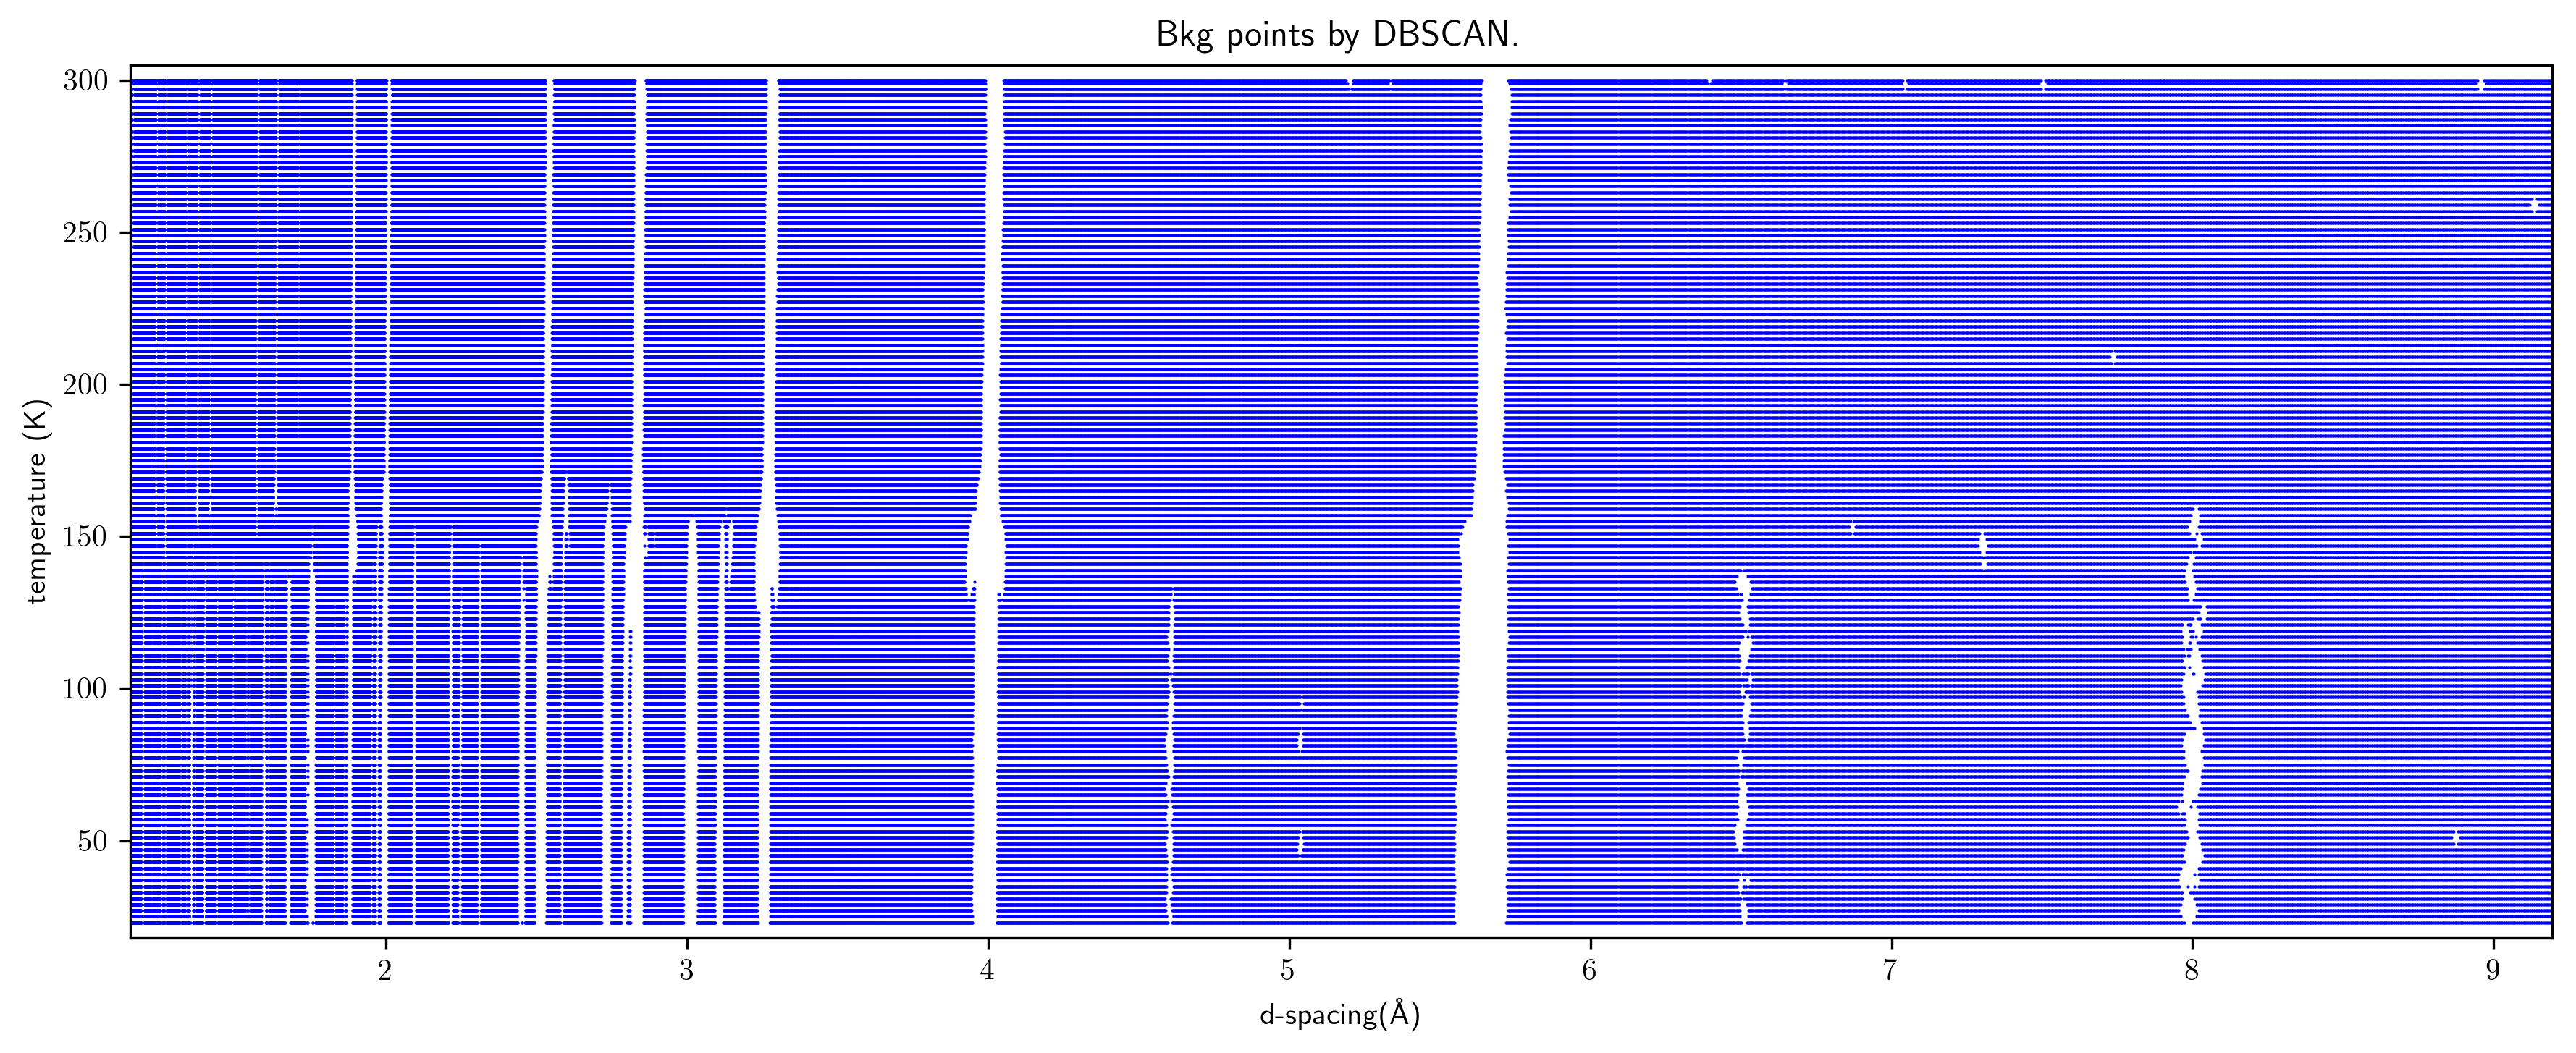

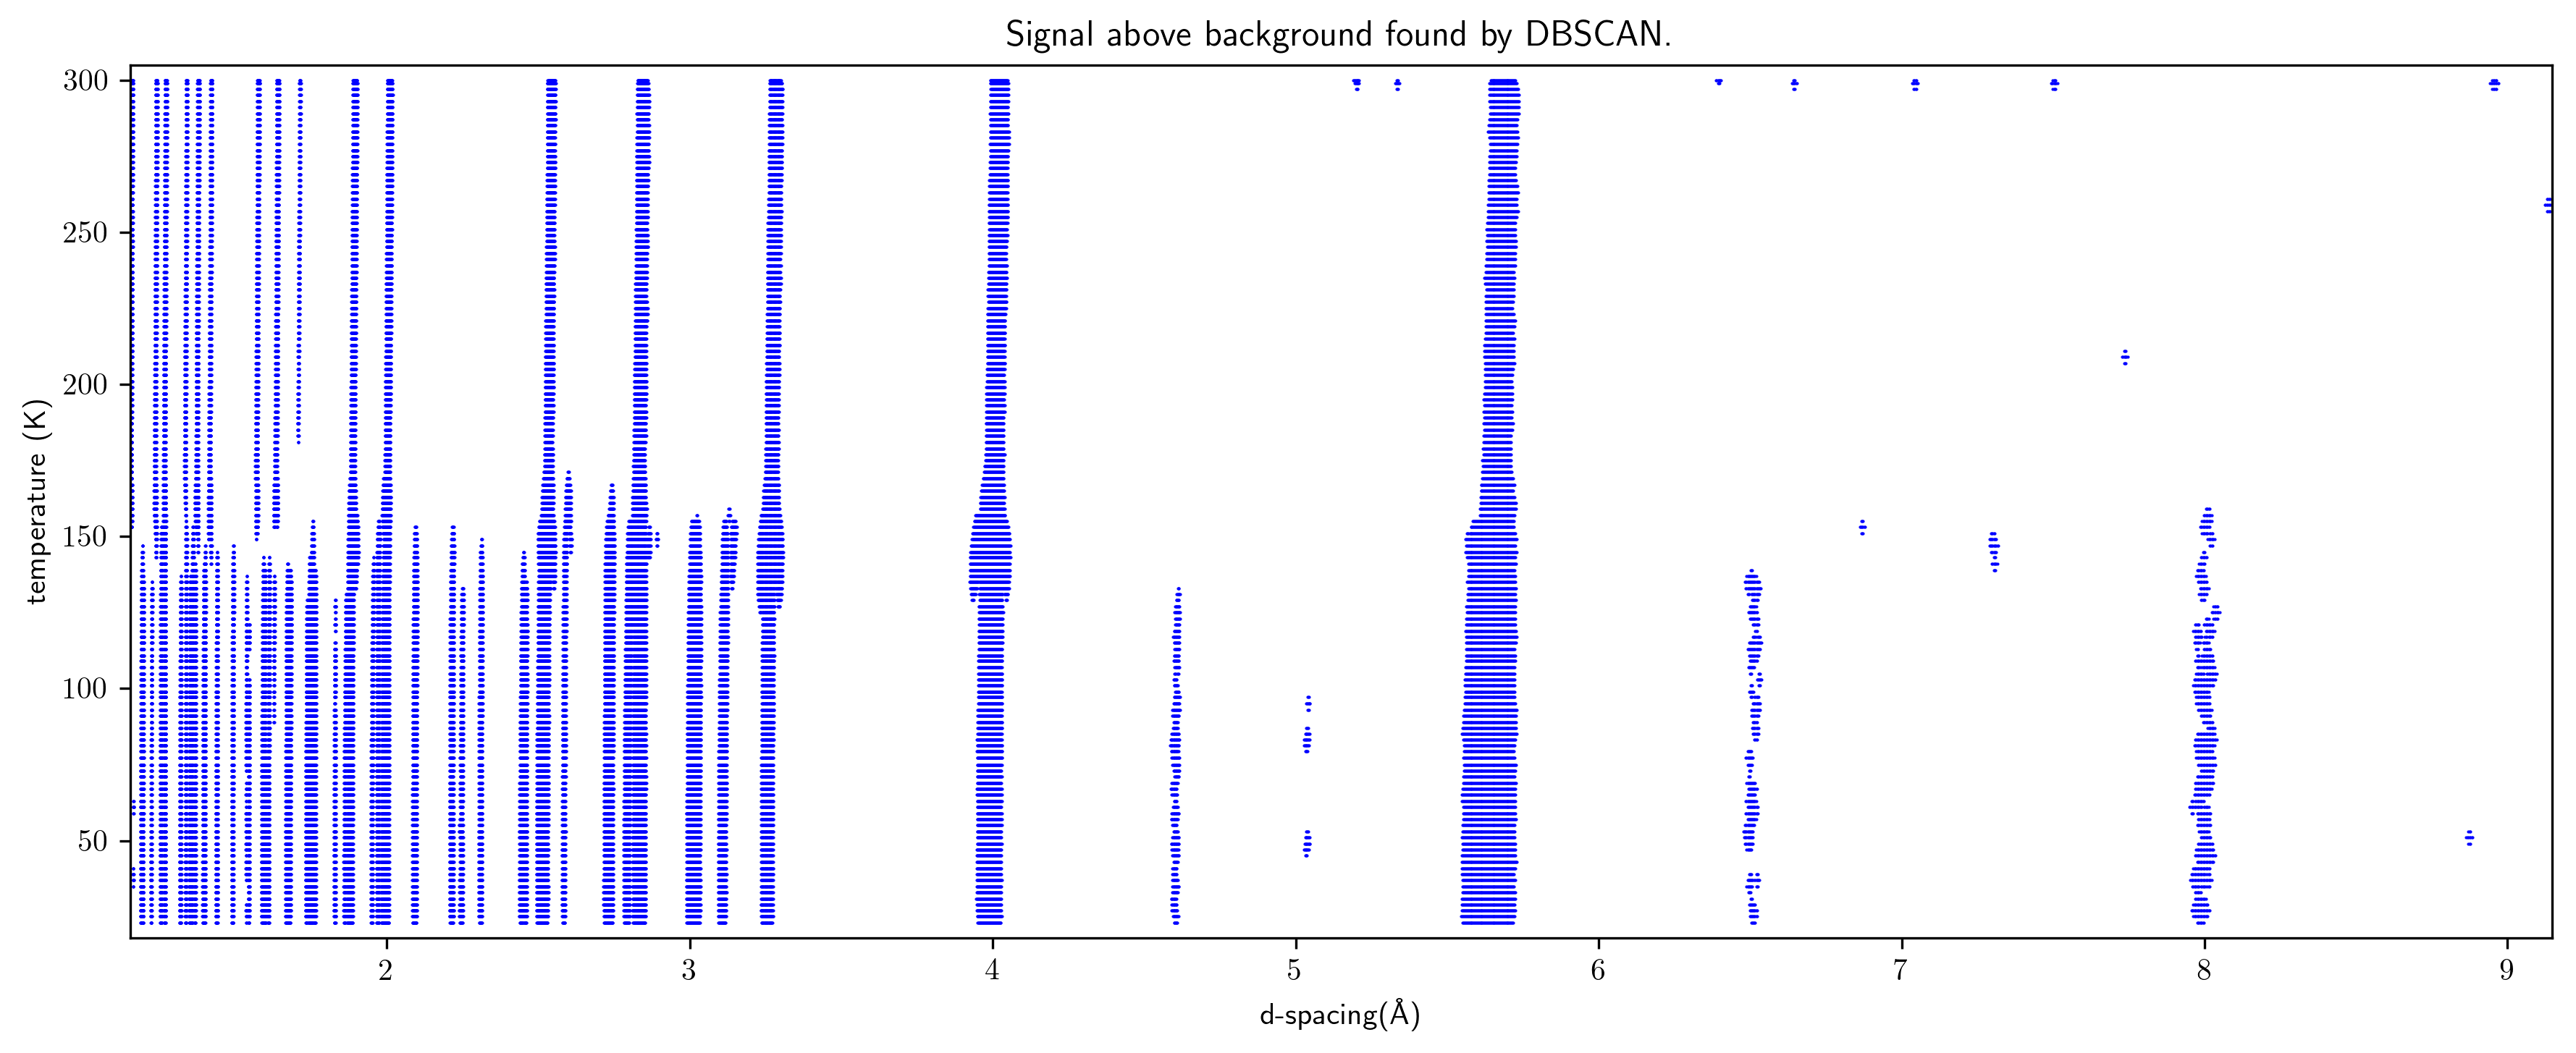

Par_order = 2, Bin_Order = 3
[  9.911e+01   1.314e-01  -1.968e-04  -1.286e+01   1.136e+00  -1.784e-02] 2 3


In [6]:
from sklearn.cluster import DBSCAN

s = 0.33
binindex = np.arange(len(dd_cs)) * s
tempindex = np.arange(len(temps))
xx, yy = np.meshgrid(binindex, tempindex)

pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T
pnt_weight = intsy.flatten()
bkg_val = np.percentile(pnt_weight, 50)
print('rough estimateion of the background level ', bkg_val)
bkg = pnt_weight[pnt_weight < bkg_val]

'''
using s=0.33, eps = 1.02 to including 7 neighbors at same temperature
and 6 at adjacent temperature.
'''
n_cutoff = np.round(13 * bkg_val  * 1.5)
db = DBSCAN(eps=1.06, min_samples=n_cutoff, n_jobs=-1).fit(pnt_loc, sample_weight = pnt_weight)
print("number of cutoff %5.2e; number ofclusters, %d, including bkg" %(n_cutoff, len(set(db.labels_))))

figsize(12, 4.8)
Plot_Clustering(db, -1, temps, dd_cs, savefilename="Q2/Figs/BKG_pnts_DBSCAN.png")
Plot_Clustering(db, 0, temps, dd_cs, savefilename="Q2/Figs/Signal_pnts_DBSCAN.png")


_xx, _yy = pnt_loc[db.labels_ == -1].T
_xx = dd_cs[(_xx/s).astype(int)]
_yy = temps[(_yy).astype(int)]
_bkg = pnt_weight[db.labels_ == -1]
Bkg_Coef, _Pars_order, _Bins_order = Opt_Globkg_order(_bkg, _yy, _xx)
print(Bkg_Coef, _Pars_order, _Bins_order)
intsy_rmbkg = rm_Global_Bkg(Bkg_Coef, intsy, temps, dd_cs, _Pars_order, _Bins_order)

## 2.2.2 Determining the center, width and integrated intensity of the signal in ROI

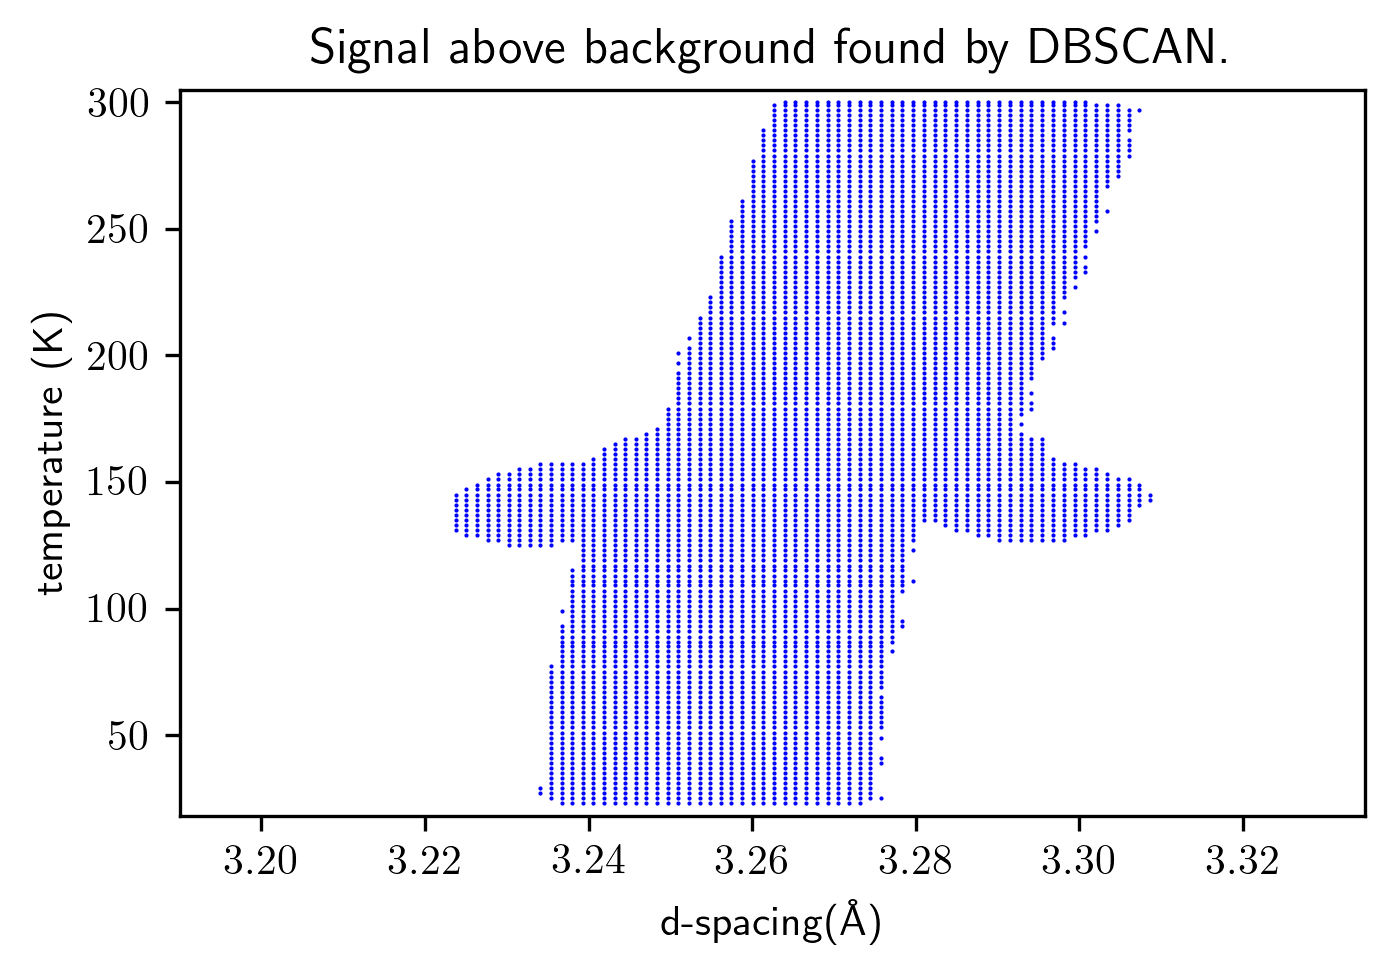

In [7]:
figsize(4.8, 3.2)
Plot_Clustering(db, 0, temps, dd_cs, x_roi=[3.19, 3.335], savefilename="Q2/Figs/Signal_ROI")

data, locs, widths, centers = Find_clusters_stats(intsy_rmbkg, db, dd_cs, x_roi=[3.2, 3.35])
datasum = np.asarray([ii.sum() for ii in data])

datastat = np.vstack((temps, datasum, widths, centers))
np.save('Q2/Data/temp_dep_signalstat_roi', datastat.T)

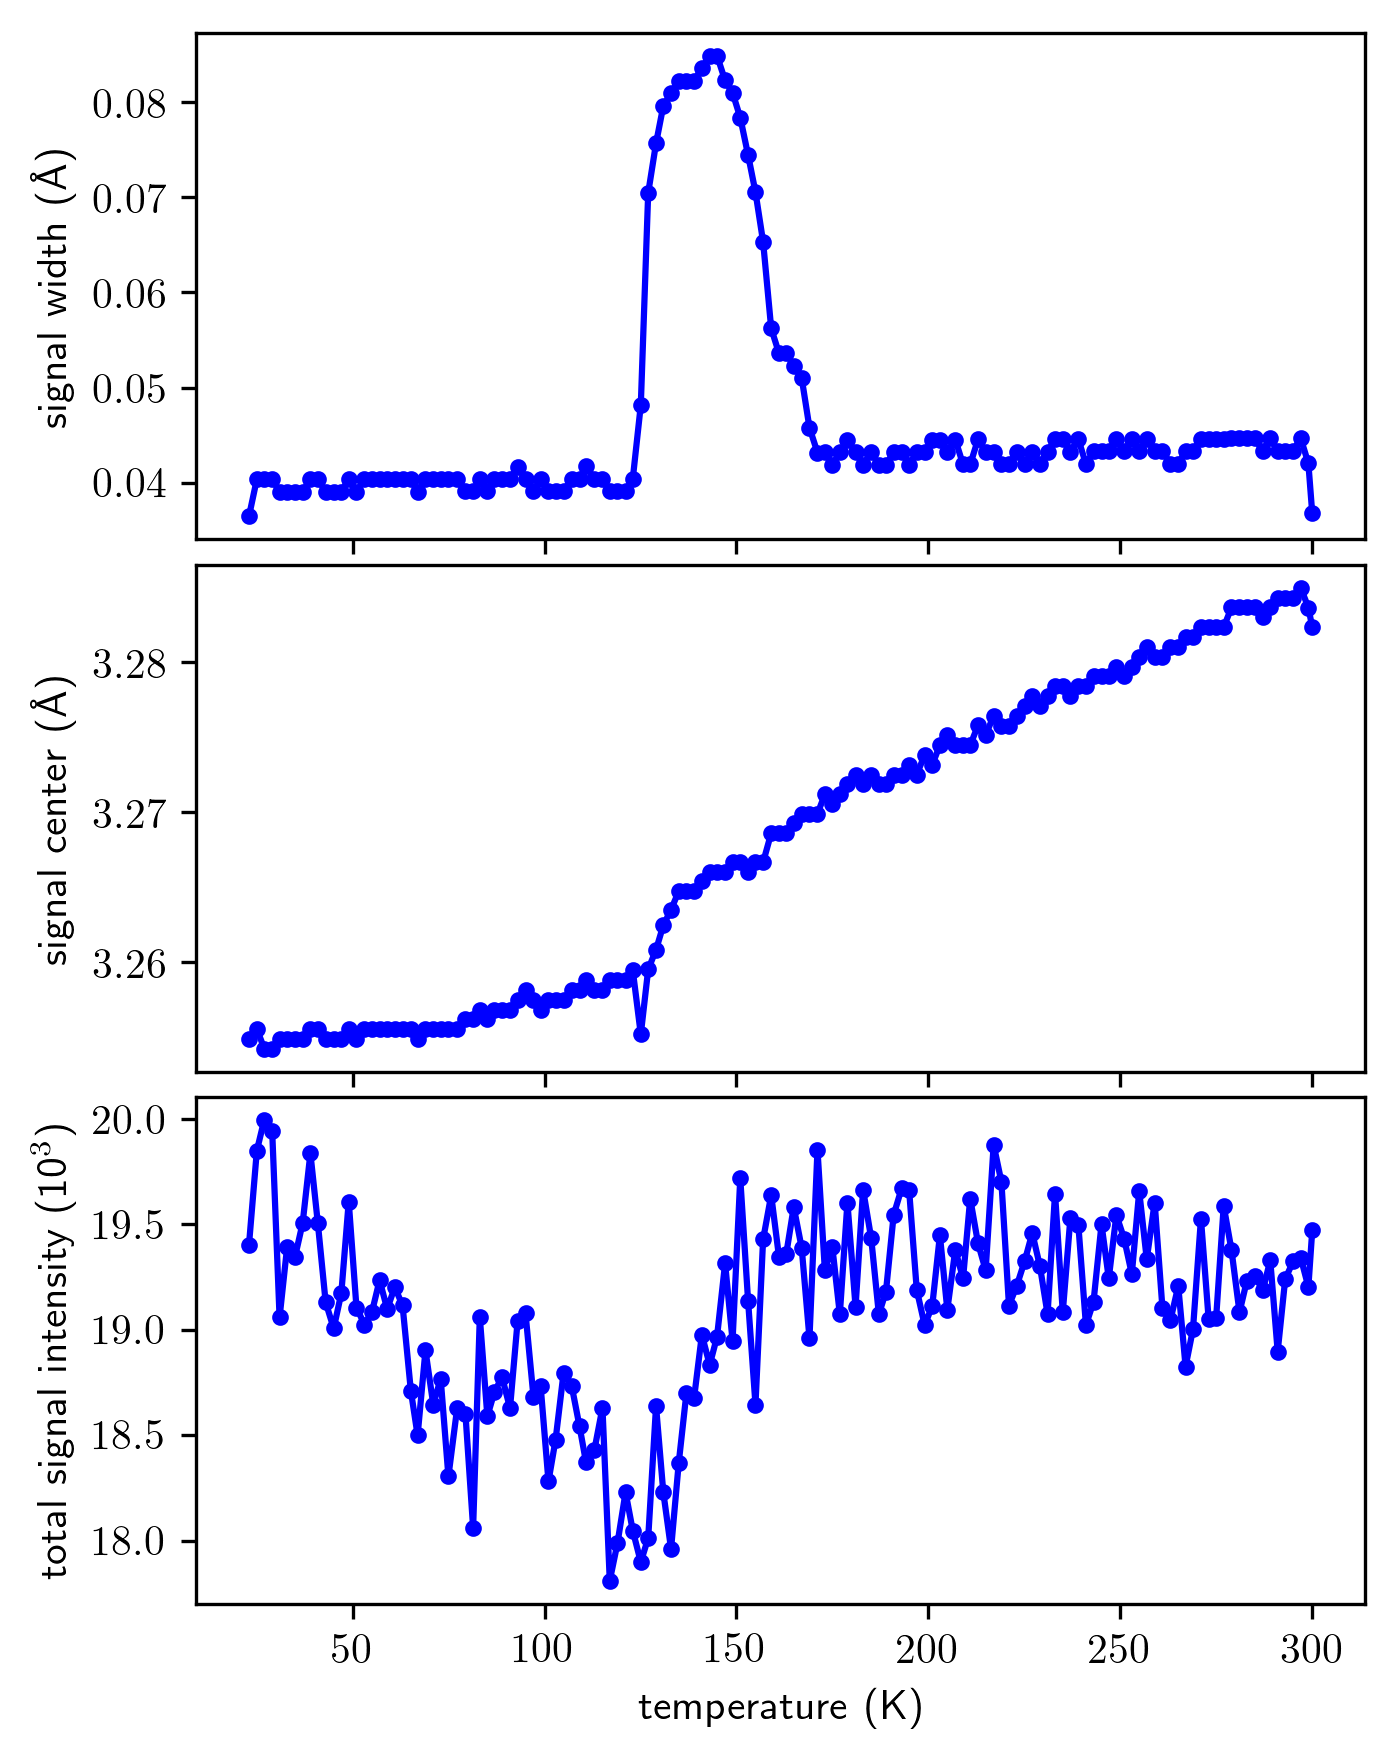

In [8]:
figsize(4.8, 6)
plt.figure()
ax1 = plt.subplot(311)
plt.plot(temps, widths, '.-', color='blue', label='signal width')
plt.ylabel('signal width (\AA)')
#plt.legend(loc=2)
ax1.set_xticklabels([])
ax2 = plt.subplot(312)
plt.plot(temps, centers, '.-', color='blue', label='signal center')
plt.ylabel('signal center (\AA)')
ax2.set_xticklabels([])
ax3 = plt.subplot(313)
plt.plot(temps, datasum/1000, '.-', color='blue', label='signal intensity')
plt.ylabel('total signal intensity (10$^3$)')
plt.xlabel('temperature (K)')
#plt.legend(loc=2)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('Q2/Figs/SignalSta_roi')

## 2.3  Alternative ways to intergrate the signal in ROI after removing the background. 

In [9]:
def Sum_Peak_Int_Gbkg(IntsyMap, exp_pars, _bins, binrange):
    '''
    A simple sum to calculate the intensity in a ROI of bins.
    bins: NXfield.
    '''
    npars, nbins = IntsyMap.shape
    
    if npars != len(exp_pars):
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
        
    if nbins != len(_bins)-1:
        raise ValueError("Dimension mismatch on number of bins.")  
    
    # define the indexes of ROI
    leftbin, rightbin = _bins.index(binrange[0]), _bins.index(binrange[1])
    
    int_sum = []
    for ii in range(npars):
        _sum = IntsyMap[ii, leftbin:rightbin].sum()
        int_sum.append(_sum)
        
    return np.asarray(int_sum)

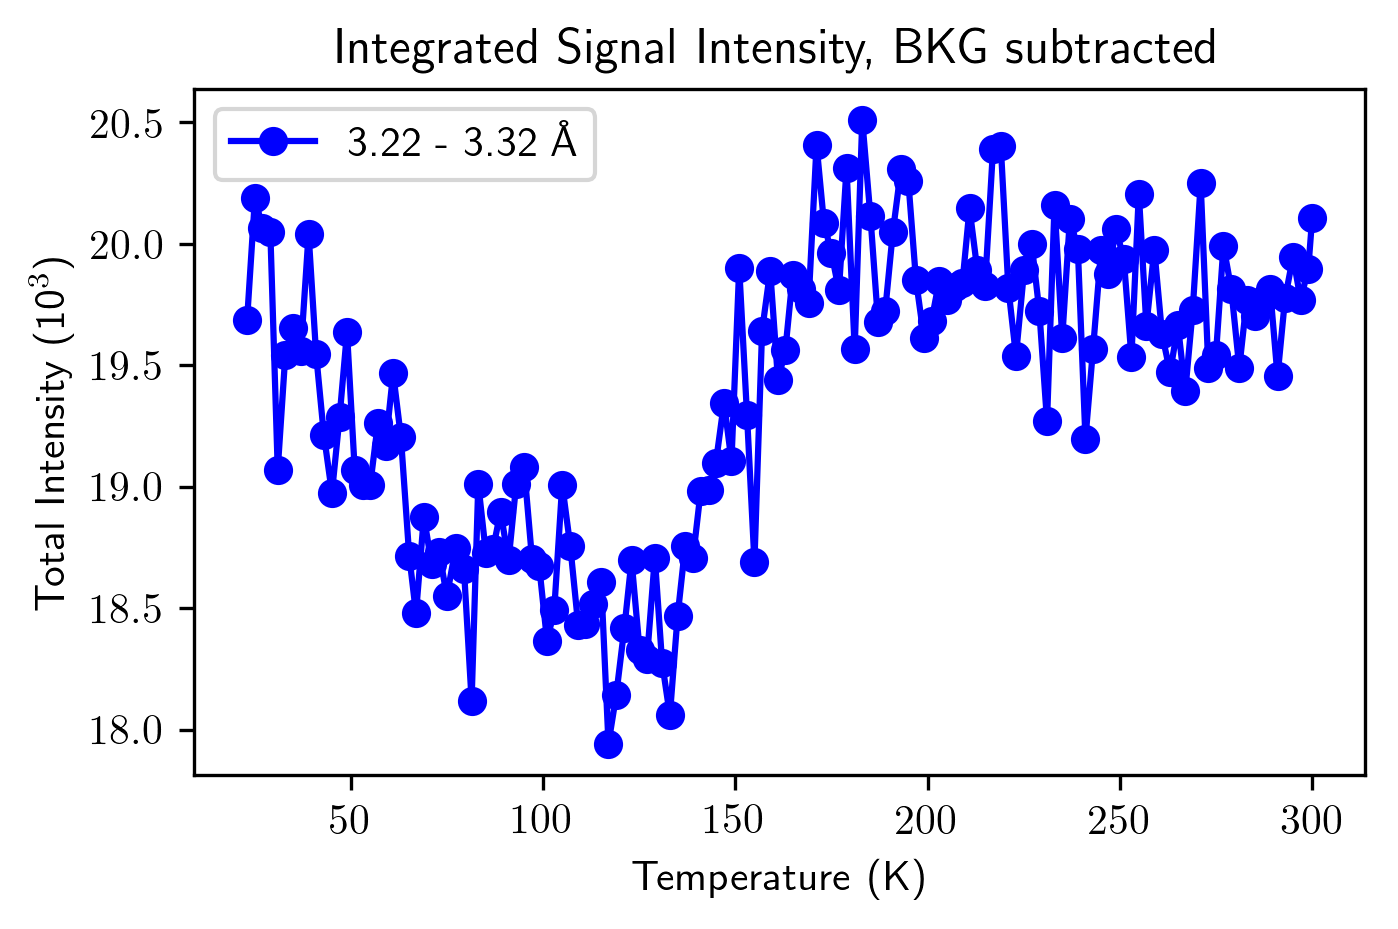

In [10]:
intsy_rmbkg = rm_Global_Bkg(Bkg_Coef, intsy, temps, dd_cs, _Pars_order, _Bins_order)
intsy_roi = Sum_Peak_Int_Gbkg(intsy_rmbkg, temps, _dds, [3.22, 3.32])
res = np.vstack((temps, intsy_roi))
np.save('Q2/Data/temp_dep_roi_rmbkg', res.T)

plt.figure(figsize(4.8, 3.2))
label = r'3.22 - 3.32 \AA' 
plt.plot(temps, intsy_roi/1000, 'o-', color='b', label=label)
plt.title('Integrated Signal Intensity, BKG subtracted')
plt.xlabel('Temperature (K)')
plt.ylabel('Total Intensity (10$^3$)')
plt.tight_layout()
plt.legend(loc=2)
plt.savefig('Q2/Figs/SingleIntensity_3p2_3p3_rm_BKG.png')
plt.show()

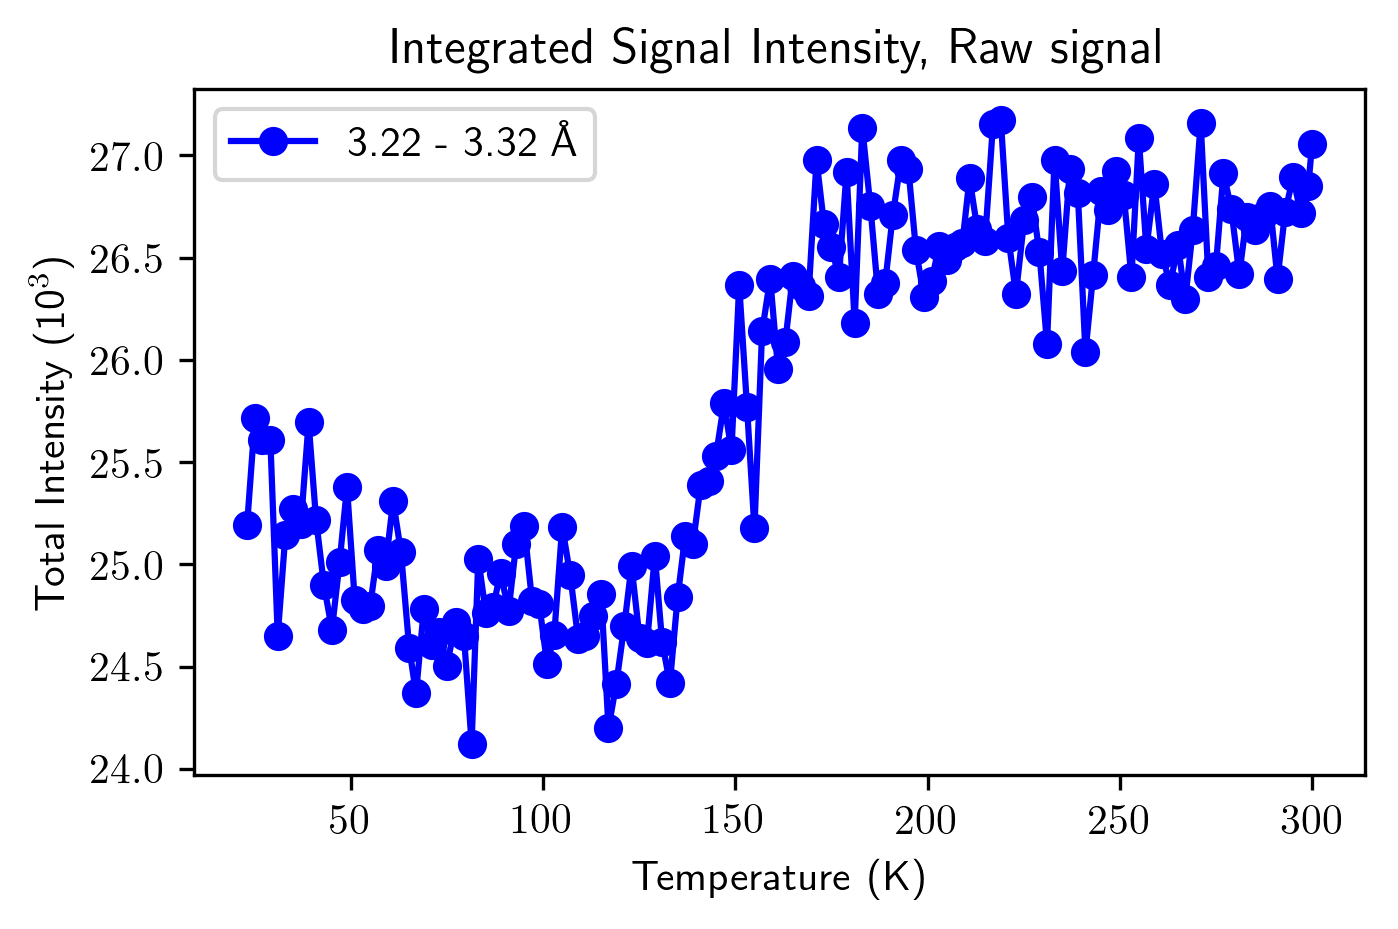

In [11]:
intsy_roi = Sum_Peak_Int_Gbkg(intsy, temps, _dds, [3.22, 3.32])
res = np.vstack((temps, intsy_roi))
np.save('Q2/Data/temp_dep_roi', res.T)

plt.figure(figsize(4.8, 3.2))
label = r'3.22 - 3.32 \AA' 
plt.plot(temps, intsy_roi/1000, 'o-', color='b', label=label)
plt.title('Integrated Signal Intensity, Raw signal')
plt.xlabel('Temperature (K)')
plt.ylabel('Total Intensity (10$^3$)')
plt.tight_layout()
plt.legend(loc=2)
plt.savefig('Q2/Figs/RawSignalIntensity_3p2_3p3.png')
plt.show()